In [1]:
!conda  list

# packages in environment at /home/alorenzo/.pyenv/versions/miniconda3/envs/map:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
asn1crypto                0.24.0                py37_1003    conda-forge
attrs                     19.1.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
bleach                    3.1.0                      py_0    conda-forge
boost-cpp                 1.68.0            h11c811c_1000    conda-forge
bzip2                     1.0.8                h516909a_1    conda-forge
ca-certificates           2019.9.11            hecc5488_0    conda-forge
cairo                     1.16.0            h18b612c_1001    conda-forge
cartopy                   0.17.0          py37h4331854_1006    conda-forge
certifi                   2019.9.11                py37_0    conda-forge
cffi                      1.12.3           py37h8022711_0 

In [2]:
from shapely.geometry import shape, MultiPolygon, mapping
import fiona
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
base_dir = Path('.')

region_paths = {int(shp.stem[-1]): shp for shp in base_dir.glob('*.shp') if 'Edited' not in shp.stem}
region_paths

{8: PosixPath('Region8.shp'),
 5: PosixPath('Region5.shp'),
 4: PosixPath('Region4.shp'),
 1: PosixPath('Region1.shp'),
 7: PosixPath('Region7.shp'),
 3: PosixPath('Region3.shp'),
 9: PosixPath('Region9.shp'),
 2: PosixPath('Region2.shp'),
 6: PosixPath('Region6.shp')}

In [4]:
region_shps = {k: fiona.collection(v, 'r') for k, v in region_paths.items()}
region_polygons = {}
for k, shp in region_shps.items():
    if len(shp) == 1:
        region_polygons[k] = shape(shp[0]['geometry'])
    else:
        region_polygons[k] = MultiPolygon([shape(shp[i]['geometry']) for i in range(len(shp)) if shp[i]['geometry'] is not None])
        
region_polygons

{8: <shapely.geometry.multipolygon.MultiPolygon at 0x7f1aca9b3eb8>,
 5: <shapely.geometry.polygon.Polygon at 0x7f1aca9b3ef0>,
 4: <shapely.geometry.polygon.Polygon at 0x7f1aca9b3748>,
 1: <shapely.geometry.polygon.Polygon at 0x7f1aca9b3f98>,
 7: <shapely.geometry.polygon.Polygon at 0x7f1aca9b3e80>,
 3: <shapely.geometry.polygon.Polygon at 0x7f1aca9b3f60>,
 9: <shapely.geometry.multipolygon.MultiPolygon at 0x7f1b02163cc0>,
 2: <shapely.geometry.polygon.Polygon at 0x7f1aca9b3f28>,
 6: <shapely.geometry.polygon.Polygon at 0x7f1aca9b36d8>}

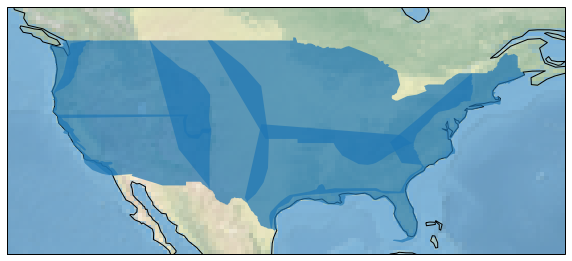

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-130, -62, 23, 48])
ax.stock_img()
ax.coastlines()
ax.add_geometries(region_polygons.values(), crs=ccrs.PlateCarree(), alpha=0.7)


In [6]:
# remove the overlap of the regions

diffs = {1: [], 8: [], 9: [], 3: [1], 2: [1, 3], 4: [2, 3], 5: [4], 6: [4, 5, 8], 7: [8, 6, 5]}
final_polygons = {}
for i, diff in diffs.items():
    final_polygons[i] = region_polygons[i]
    for d in diff:
        final_polygons[i] = final_polygons[i].difference(region_polygons[d])



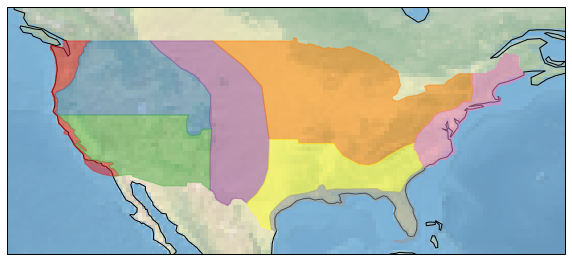

In [7]:
%matplotlib inline

COLORS = [
    "#e41a1c",
    "#377eb8",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#ffff33",
    "#f781bf",
    "#999999",                                                                                                                                                                                                                                                                                                                                         
    "#a65628",
]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-130, -62, 23, 48])
ax.stock_img()
ax.coastlines()
for i in range(1, 10):
    ax.add_geometries([final_polygons[i]], crs=ccrs.PlateCarree(), alpha=0.5, color=COLORS[i-1])


In [8]:
# save shapefiles

outdir = base_dir / 'final'
outdir.mkdir(exist_ok=True)

crs = region_shps[1].crs

for i in range(1, 10):
    new_poly = final_polygons[i]
    schema = {'properties': {'Name': 'str:254'}, 'geometry': 'Polygon'}
    with fiona.collection(outdir / f"Region_{i}.shp", "w", "ESRI Shapefile", schema=schema, crs=crs) as out:
        if isinstance(new_poly, MultiPolygon):
            for poly in new_poly:
                out.write({'properties': {'Name': f"Region {i}"}, 'geometry': mapping(poly)})
        else:
            out.write({'properties': {'Name': f'Region {i}'}, 'geometry': mapping(new_poly)})
        

In [9]:
# save geojson

crs = region_shps[1].crs

for i in range(1, 10):
    new_poly = final_polygons[i]
    schema = {'properties': {'Name': 'str:254'}, 'geometry': 'Polygon'}
    with fiona.collection(outdir / f"Region_{i}.geojson", "w", "GeoJSON", schema=schema, crs=crs) as out:
        if isinstance(new_poly, MultiPolygon):
            for poly in new_poly:
                out.write({'properties': {'Name': f"Region {i}"}, 'geometry': mapping(poly)})
        else:
            out.write({'properties': {'Name': f'Region {i}'}, 'geometry': mapping(new_poly)})

In [10]:
# save geojson in web mercator

from pyproj import Transformer
import numpy as np

transformer = Transformer.from_crs(4326, 3857, always_xy=True)

def convert_poly(poly):
    m = mapping(poly)
    coords = np.array(m['coordinates'][0])
    x, y = transformer.transform(coords[:, 0], coords[:, 1])
    m['coordinates'] = [np.array([x, y]).T.tolist()]
    return m

for i in range(1, 10):
    new_poly = final_polygons[i]
    schema = {'properties': {'Name': 'str:254'}, 'geometry': 'Polygon'}
    out_crs = {'init': 'epsg:3857'}
    with fiona.collection(outdir / f"Region_{i}.webm.geojson", "w", "GeoJSON", schema=schema, crs=out_crs) as out:
        if isinstance(new_poly, MultiPolygon):
            for poly in new_poly:
                out.write({'properties': {'Name': f"Region {i}"}, 'geometry': convert_poly(poly)})
        else:
            out.write({'properties': {'Name': f'Region {i}'}, 'geometry': convert_poly(new_poly)})

In [11]:
# convert shapefiles to kml

import subprocess

for shppath in outdir.glob('*.shp'):
    kmlpath = shppath.with_suffix('.kml')
    subprocess.run(f'ogr2ogr -f "KML" "{str(kmlpath.absolute())}" "{str(shppath.absolute())}"', shell=True)

In [12]:
# a real pain to make KMZ here, so just use Google Earth manually with KML files